In [3]:
#my modules
from bass_lv import SVBassLV
from heston import Heston, implied_vol
from utils import StochasticVolatilityModel, Density, mc_iv, bs_call_price
from reference_models import BrownianMotion_R

#modules
from math import *
import numpy as np
import matplotlib.pyplot as plt

### Create a sample market model

In [4]:
#create the market marginals as an objects with functions from Heston model
model = Heston(s0 = 100, v0 = 0.1, kappa = 2, theta = 0.07, xi = 1, rho = -0.7)
T = [0.25, 0.7, 1]
market_marginal_1 = Density(model.cdf_interpolate(0.25), model.quantile_interpolate(0.25))
market_marginal_2 = Density(model.cdf_interpolate(0.7), model.quantile_interpolate(0.7))
market_marginal_3 = Density(model.cdf_interpolate(1), model.quantile_interpolate(1))

In [5]:
#Create a reference model, which is a Brownian motion in our case
sv_model = StochasticVolatilityModel(100)
bass = SVBassLV(100, sv_model, {0.25: market_marginal_1, 0.7: market_marginal_2, 1: market_marginal_3})

#calibration example for the Heston market marginals
bass.calibrate(tolerance = 0.001, max_iter = 100, N = 10_000, nsigma = 5)

first BM is constructed
next interval with delta: 0.44999999999999996
bounds are: (array(11.58509573), array(185.06045466))
iter: 0, error: 0.049118444316525345
iter: 1, error: 0.013996646730538354
iter: 2, error: 0.006045819826444698
iter: 3, error: 0.0027350708757691855
iter: 4, error: 0.0012774554996018983
Brenier map for maturity 0.7 is constructed error = 0.0006177416639311373
next interval with delta: 0.30000000000000004
bounds are: (array(6.73727322), array(201.20321195))
iter: 0, error: 0.06591453133223324
iter: 1, error: 0.04012060907601367
iter: 2, error: 0.025339620948825248
iter: 3, error: 0.016879742522536767
iter: 4, error: 0.01169702609678247
iter: 5, error: 0.00832747977047843
iter: 6, error: 0.006040728917154237
iter: 7, error: 0.004441300359063316
iter: 8, error: 0.003297324488508502
iter: 9, error: 0.0024659946150943357
iter: 10, error: 0.0018547322846920178
iter: 11, error: 0.0014014779546837053
iter: 12, error: 0.0010627809452868897
Brenier map for maturity 1.0 is 

/Users/aleksandrpolakov/Desktop/Курсовая МатФак/Code/bass_lv/heston.py:41: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  1/pi * quad(integrand, 0, inf, epsrel=1e-12, epsabs=1e-20)[0])


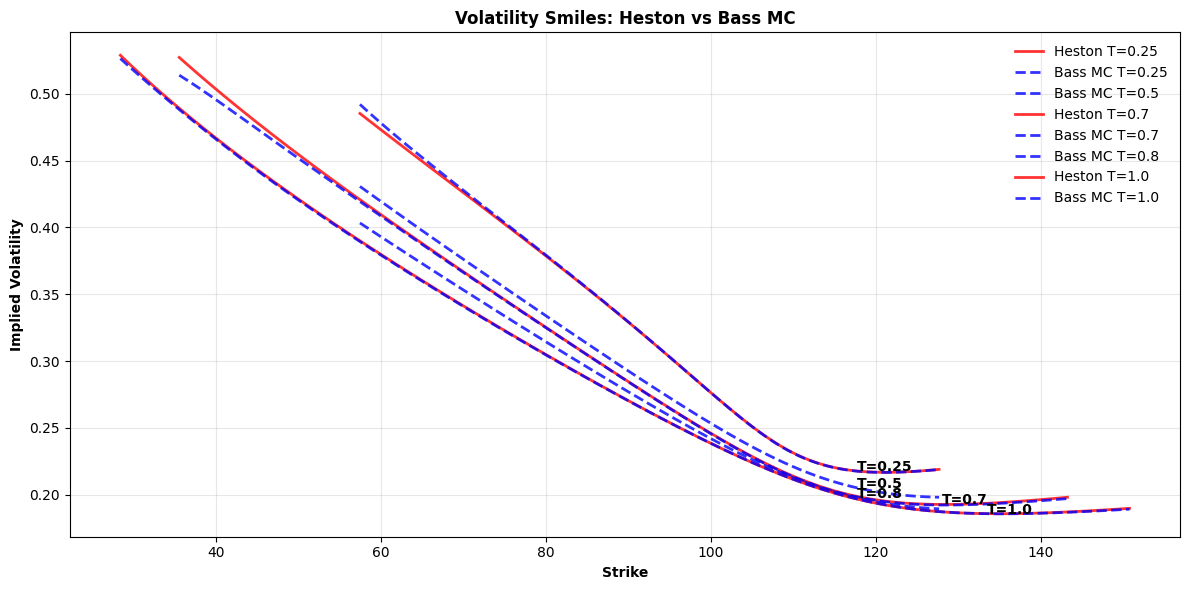

In [6]:
#Plotting
T_vals = [0.25, 0.5, 0.7, 0.8, 1.0]
T_model = [0.25, 0.7, 1.0] # Only these maturities have model plots
mc_data = {T: bass.simulate_smile(1_000_000, T) for T in T_vals} 
marginals = [market_marginal_1, None, market_marginal_2, None, market_marginal_3]

plt.figure(figsize=(12, 6))

for i, T in enumerate(T_vals):
    # Strike range
    marg = marginals[i] or market_marginal_1
    K = np.linspace(marg.qf(0.01), marg.qf(0.99), 100)
    
    # Plot model only for specific maturities
    if T in T_model:
        model_vol = model.implied_vol(T, K)
        plt.plot(K, model_vol, 'r-', linewidth=2, alpha=0.8, 
                 label=f'Heston T={T}')
        label_y = model_vol[-15]
    else:
        label_y = mc_iv(model.s0, T, K, mc_data[T])[-15]
    
    # Always plot MC
    plt.plot(K, mc_iv(model.s0, T, K, mc_data[T]), 'b--', linewidth=2, alpha=0.8,
             label=f'Bass MC T={T}')
    
    # Add maturity label
    plt.text(K[-15], label_y, f'T={T}', fontweight='bold')

plt.xlabel('Strike', fontweight='bold')
plt.ylabel('Implied Volatility', fontweight='bold') 
plt.title('Volatility Smiles: Heston vs Bass MC', fontweight='bold')
plt.legend(frameon=False)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

In [7]:
#Simulation of contineous paths
final_paths, xi_paths = bass.simulate_paths(10000, 100)

steps split between maturities = [25, 45, 30]
time interval = 0.25
time interval = 0.44999999999999996
time interval = 0.30000000000000004


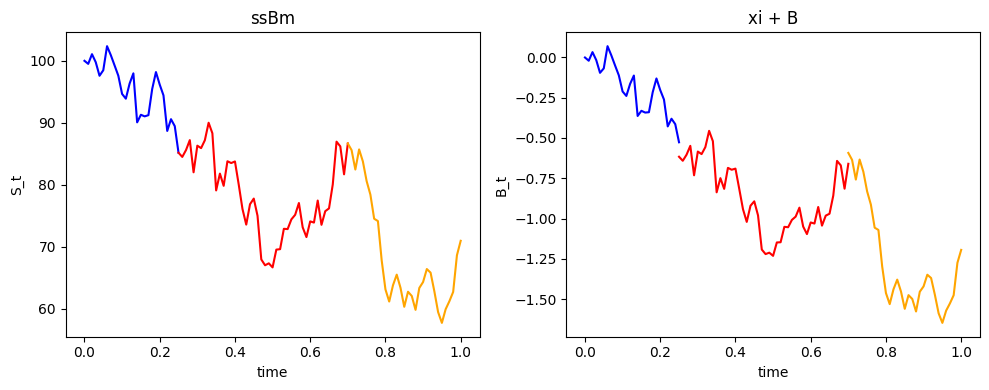

In [8]:
#Plotting

T = [0.25, 0.7, 1]
# Create sample data
x1 = np.linspace(0, T[0], len(xi_paths[0][0]))
x2 = np.linspace(T[0], T[1], len(xi_paths[1][0]))
x3 = np.linspace(T[1], T[2], len(xi_paths[2][0]))

# Create a figure and a set of subplots.
# The '1, 2' argument means 1 row and 2 columns of subplots.
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

# Plot on the first subplot (ax1)
ax1.plot(x1, final_paths[0][0], color='blue')
ax1.plot(x2, final_paths[1][0], color='red')
ax1.plot(x3, final_paths[2][0], color='orange')
ax1.set_title('ssBm')
ax1.set_xlabel('time')
ax1.set_ylabel('S_t')

# Plot on the second subplot (ax2)
ax2.plot(x1, xi_paths[0][0], color='blue')
ax2.plot(x2, xi_paths[1][0], color='red')
ax2.plot(x3, xi_paths[2][0], color='orange')
ax2.set_title('xi + B')
ax2.set_xlabel('time')
ax2.set_ylabel('B_t')

# Adjust layout to prevent titles and labels from overlapping
plt.tight_layout()

# Display the plot
plt.show()